In [5]:
# 📦 导入库
import os
import socket
import json
import time
import cv2
import h5py
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from datetime import datetime, timedelta
from PIL import Image
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

from torch.utils.data import DataLoader
import multiprocessing
import time
import numpy as np
import torch
from torch.cuda.amp import autocast

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import torch
from torch.optim.lr_scheduler import CosineAnnealingLR

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torchvision.models import get_model_weights

from sklearn.model_selection import GroupKFold, KFold
from sklearn.metrics import r2_score

# ⚙️ 全局配置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 初始化
if socket.gethostname() == 'hao-2':
    dir = Path('D:/DATA_hao/Kaggle_/csiro-biomass/')
    DIRS = {
    "dir":        dir,                                       
    "train":     Path(dir, "train"),                              
    "test":     Path(dir, "test"),                              
    "model":     Path(dir,"DualStream_multihead"),              
    "data":     Path(dir),   
    }
    
    # # 打印时一行一个地址
    # print("✅ 路径：\n")
    # for key, path in DIRS.items():
    #     print(f"{key:<12} : {path}")
else:
    dir = Path('/kaggle/input/csiro-biomass')
    DIRS = {
    "dir":        dir,                                       
    "train":     Path(dir, "train"),                              
    "test":     Path(dir, "test"),                              
    "model":     Path('/kaggle/input', "dualstream-multihead-model"),              
    "data":     Path("/kaggle/working/"),   
    }

    # # 打印时一行一个地址
    # print("✅ 路径：\n")
    # for key, path in DIRS.items():
    #     print(f"{key:<12} : {path}")

# 小函数
def show_df_info(df, name: str):
    """
    打印单个 DataFrame 的形状与列名信息。
    参数:
        df   : pandas.DataFrame
        name : 显示名称（字符串）
    """
    print(f"📊 {name:<16} shape: {str(df.shape):<16}  列名: {df.columns.tolist()}")

def move_column_first(df, col_name):
    """
    将 DataFrame 中指定列移动到最前面。
    参数:
        df (pd.DataFrame): 原始数据框
        col_name (str): 要移动到最前面的列名
    返回:
        pd.DataFrame: 调整后的新 DataFrame
    """
    if col_name not in df.columns:
        raise ValueError(f"列 '{col_name}' 不存在于 DataFrame 中。")

    cols = [col_name] + [c for c in df.columns if c != col_name]
    return df[cols]

# 🧮 后处理函数（恢复 5 个目标）
def recover_all_targets(df_pred_3):
    df = df_pred_3.copy()
    df["Dry_Clover_g"] = np.maximum(0, df["GDM_g"] - df["Dry_Green_g"])
    df["Dry_Dead_g"] = np.maximum(0, df["Dry_Total_g"] - df["GDM_g"])
    return df[["Dry_Green_g", "Dry_Dead_g", "Dry_Clover_g", "GDM_g", "Dry_Total_g"]]



In [6]:
# 📘 训练数据读取与预处理
def load_and_prepare_train_df():
    # 1️⃣ 读取原始数据
    df_file_path = Path(DIRS["dir"]) / "train.csv"
    df = pd.read_csv(df_file_path)
    # show_df_info(df, "train.csv")

    # 2️⃣ 提取唯一 ID（例如 "ID1011485656__Dry_Green_g" → "ID1011485656"）
    df["ID"] = df["sample_id"].str.split("__").str[0]

    # 3️⃣ 将 ID 列移动到最前面
    df = move_column_first(df, "ID")
    # show_df_info(df, "df")

    # 4️⃣ 目标值透视（行转列）
    df_targets = (
        df
        .pivot_table(
            index="ID",
            columns="target_name",
            values="target",
            aggfunc="first"
        )
        .reset_index()
    )
    df_targets.columns.name = None  # 去掉多级列名层次
    # show_df_info(df_targets, "df_targets")

    # 5️⃣ 提取元信息（每个 ID 仅保留一行）
    meta_cols = [
        "ID", "image_path", "Sampling_Date", "State",
        "Species", "Pre_GSHH_NDVI", "Height_Ave_cm"
    ]
    df_meta = df[meta_cols].drop_duplicates(subset="ID")
    # show_df_info(df_meta, "df_meta")

    # 6️⃣ 合并元信息与目标数据
    df_train = pd.merge(df_meta, df_targets, on="ID", how="left")
    show_df_info(df_train, "df_train")

    
    return df_train



# 加载数据

In [9]:
df_pred_CMT = pd.read_excel(r"D:\DATA_hao\Kaggle_\csiro-biomass\DualStream_multihead\main_pipline_GPU_CMT\df_pred_final.xlsx")
df_pred_GCD = pd.read_excel(r"D:\DATA_hao\Kaggle_\csiro-biomass\DualStream_multihead\main_pipline_GPU_GCD\df_pred_final.xlsx")
df_true = load_and_prepare_train_df()

cols = ['ID', 'Dry_Green_g', 'Dry_Clover_g', 'Dry_Dead_g', 'GDM_g', 'Dry_Total_g']

# 只保留关心列并按 ID 排序
df_true      = df_true[cols].sort_values('ID').reset_index(drop=True)
df_pred_CMT  = df_pred_CMT[cols].sort_values('ID').reset_index(drop=True)
df_pred_GCD  = df_pred_GCD[cols].sort_values('ID').reset_index(drop=True)


# 验证是否完全匹配
assert all(df_true['ID'] == df_pred_CMT['ID']) and all(df_true['ID'] == df_pred_GCD['ID']), "❌ ID 不匹配，请检查。"


print(df_pred_CMT.head())
print(df_pred_GCD.head())
print(df_true.head())


📊 df_train         shape: (357, 12)         列名: ['ID', 'image_path', 'Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm', 'Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g', 'GDM_g']
             ID  Dry_Green_g  Dry_Clover_g  Dry_Dead_g      GDM_g  Dry_Total_g
0  ID1011485656    19.422518      0.026387   33.974426  19.448904    53.423328
1  ID1012260530     6.795019      0.241260    1.103543   7.036278     8.116562
2  ID1025234388     2.312593      3.467346    0.731823   5.574284     6.305750
3  ID1028611175    21.915634      0.276643   32.589611  22.192282    54.781887
4  ID1035947949    11.207839      0.488699   19.362097  11.696538    31.058634
             ID  Dry_Green_g  Dry_Clover_g  Dry_Dead_g      GDM_g  Dry_Total_g
0  ID1011485656    21.362541      4.191726   25.592787  25.554268    51.147053
1  ID1012260530     5.183845      0.823314    0.547308   6.007159     6.554467
2  ID1025234388     0.387431      5.721556    0.167631   6.108986     6.276618
3

# 全局 Kaggle R²

In [ ]:
def compute_kaggle_r2(df_true, df_pred):
    # 指定目标列顺序（Kaggle 官方定义）
    target_cols = ['Dry_Green_g', 'Dry_Clover_g', 'Dry_Dead_g', 'GDM_g', 'Dry_Total_g']
    weights = np.array([0.1, 0.1, 0.1, 0.2, 0.5], dtype=float)

    # 转换为 numpy 数组 (float)
    y_true = df_true[target_cols].to_numpy(dtype=float)
    y_pred = df_pred[target_cols].to_numpy(dtype=float)

    # 展平
    y_true_flat = np.concatenate([y_true[:, i] for i in range(5)])
    y_pred_flat = np.concatenate([y_pred[:, i] for i in range(5)])
    w_flat = np.concatenate([
        np.full_like(y_true[:, i], weights[i], dtype=float)
        for i in range(5)
    ])

    # 计算全局加权 R²
    y_mean = np.sum(w_flat * y_true_flat) / np.sum(w_flat)
    ss_res = np.sum(w_flat * (y_true_flat - y_pred_flat) ** 2)
    ss_tot = np.sum(w_flat * (y_true_flat - y_mean) ** 2)

    r2_global = 1 - ss_res / ss_tot
    return r2_global


In [13]:
r2_CMT = compute_kaggle_r2(df_true, df_pred_CMT)
r2_GCD = compute_kaggle_r2(df_true, df_pred_GCD)

print(f"🌿 方案 B (CMT) 全局加权 R² = {r2_CMT:.6f}")
print(f"🌾 方案 A (GCD) 全局加权 R² = {r2_GCD:.6f}")

🌿 方案 B (CMT) 全局加权 R² = 0.915459
🌾 方案 A (GCD) 全局加权 R² = 0.924776


# 平均噪声比例（反推 noise level）

In [12]:
def estimate_noise_levels(df_true, df_pred, min_value=1.0):
    """
    估计每个目标的相对误差标准差（噪声比例），自动跳过真实值过小的样本。
    min_value: 小于该值的真实样本不会参与相对误差计算
    """
    cols = ['Dry_Green_g', 'Dry_Clover_g', 'Dry_Dead_g', 'GDM_g', 'Dry_Total_g']
    noise_stats = {}

    for col in cols:
        y_true = df_true[col].to_numpy(dtype=float)
        y_pred = df_pred[col].to_numpy(dtype=float)

        # 只取真实值大于 min_value 的样本（避免除以0）
        mask = y_true > min_value
        if mask.sum() == 0:
            noise_stats[col] = {"mean_relative_bias": np.nan, "std_relative_noise": np.nan}
            continue

        rel_error = (y_pred[mask] - y_true[mask]) / y_true[mask]
        noise_stats[col] = {
            "mean_relative_bias": np.mean(rel_error),
            "std_relative_noise": np.std(rel_error)
        }

    return pd.DataFrame(noise_stats).T


In [15]:
noise_CMT = estimate_noise_levels(df_true, df_pred_CMT, min_value=1.0)
noise_GCD = estimate_noise_levels(df_true, df_pred_GCD, min_value=1.0)

print("🌿 方案 B (CMT) 噪声统计")
print(noise_CMT)
print("\n🌾 方案 A (GCD) 噪声统计")
print(noise_GCD)


🌿 方案 B (CMT) 噪声统计
              mean_relative_bias  std_relative_noise
Dry_Green_g             0.450723            2.178395
Dry_Clover_g           -0.389541            0.368100
Dry_Dead_g              0.128113            0.584366
GDM_g                   0.040060            0.266304
Dry_Total_g             0.020094            0.228356

🌾 方案 A (GCD) 噪声统计
              mean_relative_bias  std_relative_noise
Dry_Green_g             0.182256            0.778492
Dry_Clover_g            0.317315            0.606169
Dry_Dead_g             -0.068135            0.432153
GDM_g                   0.178411            0.374004
Dry_Total_g             0.032375            0.214623


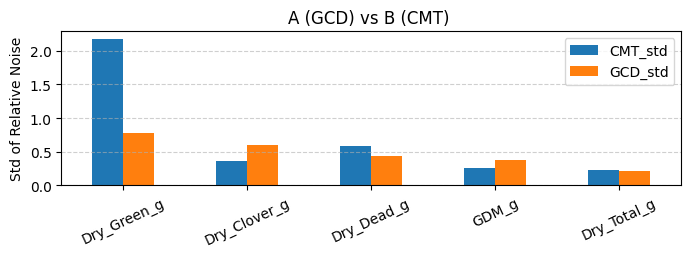

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

# 合并结果，方便画图
noise_compare = pd.DataFrame({
    "CMT_std": noise_CMT["std_relative_noise"],
    "GCD_std": noise_GCD["std_relative_noise"]
})

noise_compare.plot(kind='bar', figsize=(8,2))
plt.ylabel("Std of Relative Noise")
plt.title("A (GCD) vs B (CMT) ")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=25)
plt.show()
